In [4]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
r"""Simple transfer learning with Inception v3 or Mobilenet models.

With support for TensorBoard.

This example shows how to take a Inception v3 or Mobilenet model trained on
ImageNet images, and train a new top layer that can recognize other classes of
images.

The top layer receives as input a 2048-dimensional vector (1001-dimensional for
Mobilenet) for each image. We train a softmax layer on top of this
representation. Assuming the softmax layer contains N labels, this corresponds
to learning N + 2048*N (or 1001*N)  model parameters corresponding to the
learned biases and weights.

Here's an example, which assumes you have a folder containing class-named
subfolders, each full of images for each label. The example folder flower_photos
should have a structure like this:

~/flower_photos/daisy/photo1.jpg
~/flower_photos/daisy/photo2.jpg
...
~/flower_photos/rose/anotherphoto77.jpg
...
~/flower_photos/sunflower/somepicture.jpg

The subfolder names are important, since they define what label is applied to
each image, but the filenames themselves don't matter. Once your images are
prepared, you can run the training with a command like this:


```bash
bazel build tensorflow/examples/image_retraining:retrain && \
bazel-bin/tensorflow/examples/image_retraining/retrain \
    --image_dir ~/flower_photos
```

Or, if you have a pip installation of tensorflow, `retrain.py` can be run
without bazel:

```bash
python tensorflow/examples/image_retraining/retrain.py \
    --image_dir ~/flower_photos
```

You can replace the image_dir argument with any folder containing subfolders of
images. The label for each image is taken from the name of the subfolder it's
in.

This produces a new model file that can be loaded and run by any TensorFlow
program, for example the label_image sample code.

By default this script will use the high accuracy, but comparatively large and
slow Inception v3 model architecture. It's recommended that you start with this
to validate that you have gathered good training data, but if you want to deploy
on resource-limited platforms, you can try the `--architecture` flag with a
Mobilenet model. For example:

```bash
python tensorflow/examples/image_retraining/retrain.py \
    --image_dir ~/flower_photos --architecture mobilenet_1.0_224
```

There are 32 different Mobilenet models to choose from, with a variety of file
size and latency options. The first number can be '1.0', '0.75', '0.50', or
'0.25' to control the size, and the second controls the input image size, either
'224', '192', '160', or '128', with smaller sizes running faster. See
https://research.googleblog.com/2017/06/mobilenets-open-source-models-for.html
for more information on Mobilenet.

To use with TensorBoard:

By default, this script will log summaries to /tmp/retrain_logs directory

Visualize the summaries with this command:

tensorboard --logdir /tmp/retrain_logs

"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
from datetime import datetime
import hashlib
import os.path
import random
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import tensor_shape
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

FLAGS = None

# These are all parameters that are tied to the particular model architecture
# we're using for Inception v3. These include things like tensor names and their
# sizes. If you want to adapt this script to work with another model, you will
# need to update these to reflect the values in the network you're using.
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M


def create_image_lists(image_dir, testing_percentage, validation_percentage):
  """Builds a list of training images from the file system.

  Analyzes the sub folders in the image directory, splits them into stable
  training, testing, and validation sets, and returns a data structure
  describing the lists of images for each label and their paths.

  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.

  Returns:
    A dictionary containing an entry for each label subfolder, with images split
    into training, testing, and validation sets within each label.
  """
  if not gfile.Exists(image_dir):
    tf.logging.error("Image directory '" + image_dir + "' not found.")
    return None
  result = collections.OrderedDict()
  sub_dirs = [
    os.path.join(image_dir,item)
    for item in gfile.ListDirectory(image_dir)]
  sub_dirs = sorted(item for item in sub_dirs
                    if gfile.IsDirectory(item))
  for sub_dir in sub_dirs:
    extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
    file_list = []
    dir_name = os.path.basename(sub_dir)
    if dir_name == image_dir:
      continue
    tf.logging.info("Looking for images in '" + dir_name + "'")
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(gfile.Glob(file_glob))
    if not file_list:
      tf.logging.warning('No files found')
      continue
    if len(file_list) < 20:
      tf.logging.warning(
          'WARNING: Folder has less than 20 images, which may cause issues.')
    elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
      tf.logging.warning(
          'WARNING: Folder {} has more than {} images. Some images will '
          'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []
    for file_name in file_list:
      base_name = os.path.basename(file_name)
      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put an image in, the data set creator has a way of
      # grouping photos that are close variations of each other. For example
      # this is used in the plant disease data set to group multiple pictures of
      # the same leaf.
      hash_name = re.sub(r'_nohash_.*$', '', file_name)
      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.
      hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_IMAGES_PER_CLASS))
      if percentage_hash < validation_percentage:
        validation_images.append(base_name)
      elif percentage_hash < (testing_percentage + validation_percentage):
        testing_images.append(base_name)
      else:
        training_images.append(base_name)
    result[label_name] = {
        'dir': dir_name,
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  return result


def get_image_path(image_lists, label_name, index, image_dir, category):
  """"Returns a path to an image for a label at the given index.

  Args:
    image_lists: Dictionary of training images for each label.
    label_name: Label string we want to get an image for.
    index: Int offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of set to pull images from - training, testing, or
    validation.

  Returns:
    File system path string to an image that meets the requested parameters.

  """
  if label_name not in image_lists:
    tf.logging.fatal('Label does not exist %s.', label_name)
  label_lists = image_lists[label_name]
  if category not in label_lists:
    tf.logging.fatal('Category does not exist %s.', category)
  category_list = label_lists[category]
  if not category_list:
    tf.logging.fatal('Label %s has no images in the category %s.',
                     label_name, category)
  mod_index = index % len(category_list)
  base_name = category_list[mod_index]
  sub_dir = label_lists['dir']
  full_path = os.path.join(image_dir, sub_dir, base_name)
  return full_path


def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir,
                        category, architecture):
  """"Returns a path to a bottleneck file for a label at the given index.

  Args:
    image_lists: Dictionary of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    category: Name string of set to pull images from - training, testing, or
    validation.
    architecture: The name of the model architecture.

  Returns:
    File system path string to an image that meets the requested parameters.
  """
  return get_image_path(image_lists, label_name, index, bottleneck_dir,
                        category) + '_' + architecture + '.txt'


def create_model_graph(model_info):
  """"Creates a graph from saved GraphDef file and returns a Graph object.

  Args:
    model_info: Dictionary containing information about the model architecture.

  Returns:
    Graph holding the trained Inception network, and various tensors we'll be
    manipulating.
  """
  with tf.Graph().as_default() as graph:
    model_path = os.path.join(FLAGS.model_dir, model_info['model_file_name'])
    with gfile.FastGFile(model_path, 'rb') as f:
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
      bottleneck_tensor, resized_input_tensor = (tf.import_graph_def(
          graph_def,
          name='',
          return_elements=[
              model_info['bottleneck_tensor_name'],
              model_info['resized_input_tensor_name'],
          ]))
  return graph, bottleneck_tensor, resized_input_tensor


def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            decoded_image_tensor, resized_input_tensor,
                            bottleneck_tensor):
  """Runs inference on an image to extract the 'bottleneck' summary layer.

  Args:
    sess: Current active TensorFlow Session.
    image_data: String of raw JPEG data.
    image_data_tensor: Input data layer in the graph.
    decoded_image_tensor: Output of initial image resizing and  preprocessing.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: Layer before the final softmax.

  Returns:
    Numpy array of bottleneck values.
  """
  # First decode the JPEG image, resize it, and rescale the pixel values.
  resized_input_values = sess.run(decoded_image_tensor,
                                  {image_data_tensor: image_data})
  # Then run it through the recognition network.
  bottleneck_values = sess.run(bottleneck_tensor,
                               {resized_input_tensor: resized_input_values})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values


def maybe_download_and_extract(data_url):
  """Download and extract model tar file.

  If the pretrained model we're using doesn't already exist, this function
  downloads it from the TensorFlow.org website and unpacks it into a directory.

  Args:
    data_url: Web location of the tar file containing the pretrained model.
  """
  dest_directory = FLAGS.model_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = data_url.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):

    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' %
                       (filename,
                        float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(data_url, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    tf.logging.info('Successfully downloaded', filename, statinfo.st_size,
                    'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def ensure_dir_exists(dir_name):
  """Makes sure the folder exists on disk.

  Args:
    dir_name: Path string to the folder we want to create.
  """
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)


bottleneck_path_2_bottleneck_values = {}


def create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor):
  """Create a single bottleneck file."""
  tf.logging.info('Creating bottleneck at ' + bottleneck_path)
  image_path = get_image_path(image_lists, label_name, index,
                              image_dir, category)
  if not gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
  image_data = gfile.FastGFile(image_path, 'rb').read()
  try:
    bottleneck_values = run_bottleneck_on_image(
        sess, image_data, jpeg_data_tensor, decoded_image_tensor,
        resized_input_tensor, bottleneck_tensor)
  except Exception as e:
    raise RuntimeError('Error during processing file %s (%s)' % (image_path,
                                                                 str(e)))
  bottleneck_string = ','.join(str(x) for x in bottleneck_values)
  with open(bottleneck_path, 'w') as bottleneck_file:
    bottleneck_file.write(bottleneck_string)


def get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir,
                             category, bottleneck_dir, jpeg_data_tensor,
                             decoded_image_tensor, resized_input_tensor,
                             bottleneck_tensor, architecture):
  """Retrieves or calculates bottleneck values for an image.

  If a cached version of the bottleneck data exists on-disk, return that,
  otherwise calculate the data and save it to disk for future use.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be modulo-ed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string  of the subfolders containing the training
    images.
    category: Name string of which  set to pull images from - training, testing,
    or validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: The tensor to feed loaded jpeg data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The output tensor for the bottleneck values.
    architecture: The name of the model architecture.

  Returns:
    Numpy array of values produced by the bottleneck layer for the image.
  """
  label_lists = image_lists[label_name]
  sub_dir = label_lists['dir']
  sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
  ensure_dir_exists(sub_dir_path)
  bottleneck_path = get_bottleneck_path(image_lists, label_name, index,
                                        bottleneck_dir, category, architecture)
  if not os.path.exists(bottleneck_path):
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
  with open(bottleneck_path, 'r') as bottleneck_file:
    bottleneck_string = bottleneck_file.read()
  did_hit_error = False
  try:
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  except ValueError:
    tf.logging.warning('Invalid float found, recreating bottleneck')
    did_hit_error = True
  if did_hit_error:
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
    with open(bottleneck_path, 'r') as bottleneck_file:
      bottleneck_string = bottleneck_file.read()
    # Allow exceptions to propagate here, since they shouldn't happen after a
    # fresh creation
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  return bottleneck_values


def cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir,
                      jpeg_data_tensor, decoded_image_tensor,
                      resized_input_tensor, bottleneck_tensor, architecture):
  """Ensures all the training, testing, and validation bottlenecks are cached.

  Because we're likely to read the same image multiple times (if there are no
  distortions applied during training) it can speed things up a lot if we
  calculate the bottleneck layer values once for each image during
  preprocessing, and then just read those cached values repeatedly during
  training. Here we go through all the images we've found, calculate those
  values, and save them off.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    image_dir: Root folder string of the subfolders containing the training
    images.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: Input tensor for jpeg data from file.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The penultimate output layer of the graph.
    architecture: The name of the model architecture.

  Returns:
    Nothing.
  """
  how_many_bottlenecks = 0
  ensure_dir_exists(bottleneck_dir)
  for label_name, label_lists in image_lists.items():
    for category in ['training', 'testing', 'validation']:
      category_list = label_lists[category]
      for index, unused_base_name in enumerate(category_list):
        get_or_create_bottleneck(
            sess, image_lists, label_name, index, image_dir, category,
            bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, architecture)

        how_many_bottlenecks += 1
        if how_many_bottlenecks % 100 == 0:
          tf.logging.info(
              str(how_many_bottlenecks) + ' bottleneck files created.')


def get_random_cached_bottlenecks(sess, image_lists, how_many, category,
                                  bottleneck_dir, image_dir, jpeg_data_tensor,
                                  decoded_image_tensor, resized_input_tensor,
                                  bottleneck_tensor, architecture):
  """Retrieves bottleneck values for cached images.

  If no distortions are being applied, this function can retrieve the cached
  bottleneck values directly from disk for images. It picks a random set of
  images from the specified category.

  Args:
    sess: Current TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
    If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_dir: Root folder string of the subfolders containing the training
    images.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
    architecture: The name of the model architecture.

  Returns:
    List of bottleneck arrays, their corresponding ground truths, and the
    relevant filenames.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  filenames = []
  if how_many >= 0:
    # Retrieve a random sample of bottlenecks.
    for unused_i in range(how_many):
      label_index = random.randrange(class_count)
      label_name = list(image_lists.keys())[label_index]
      image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
      image_name = get_image_path(image_lists, label_name, image_index,
                                  image_dir, category)
      bottleneck = get_or_create_bottleneck(
          sess, image_lists, label_name, image_index, image_dir, category,
          bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
          resized_input_tensor, bottleneck_tensor, architecture)
      ground_truth = np.zeros(class_count, dtype=np.float32)
      ground_truth[label_index] = 1.0
      bottlenecks.append(bottleneck)
      ground_truths.append(ground_truth)
      filenames.append(image_name)
  else:
    # Retrieve all bottlenecks.
    for label_index, label_name in enumerate(image_lists.keys()):
      for image_index, image_name in enumerate(
          image_lists[label_name][category]):
        image_name = get_image_path(image_lists, label_name, image_index,
                                    image_dir, category)
        bottleneck = get_or_create_bottleneck(
            sess, image_lists, label_name, image_index, image_dir, category,
            bottleneck_dir, jpeg_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, architecture)
        ground_truth = np.zeros(class_count, dtype=np.float32)
        ground_truth[label_index] = 1.0
        bottlenecks.append(bottleneck)
        ground_truths.append(ground_truth)
        filenames.append(image_name)
  return bottlenecks, ground_truths, filenames


def get_random_distorted_bottlenecks(
    sess, image_lists, how_many, category, image_dir, input_jpeg_tensor,
    distorted_image, resized_input_tensor, bottleneck_tensor):
  """Retrieves bottleneck values for training images, after distortions.

  If we're training with distortions like crops, scales, or flips, we have to
  recalculate the full model for every image, and so we can't use cached
  bottleneck values. Instead we find random images for the requested category,
  run them through the distortion graph, and then the full graph to get the
  bottleneck results for each.

  Args:
    sess: Current TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    how_many: The integer number of bottleneck values to return.
    category: Name string of which set of images to fetch - training, testing,
    or validation.
    image_dir: Root folder string of the subfolders containing the training
    images.
    input_jpeg_tensor: The input layer we feed the image data to.
    distorted_image: The output node of the distortion graph.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.

  Returns:
    List of bottleneck arrays and their corresponding ground truths.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  for unused_i in range(how_many):
    label_index = random.randrange(class_count)
    label_name = list(image_lists.keys())[label_index]
    image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
    image_path = get_image_path(image_lists, label_name, image_index, image_dir,
                                category)
    if not gfile.Exists(image_path):
      tf.logging.fatal('File does not exist %s', image_path)
    jpeg_data = gfile.FastGFile(image_path, 'rb').read()
    # Note that we materialize the distorted_image_data as a numpy array before
    # sending running inference on the image. This involves 2 memory copies and
    # might be optimized in other implementations.
    distorted_image_data = sess.run(distorted_image,
                                    {input_jpeg_tensor: jpeg_data})
    bottleneck_values = sess.run(bottleneck_tensor,
                                 {resized_input_tensor: distorted_image_data})
    bottleneck_values = np.squeeze(bottleneck_values)
    ground_truth = np.zeros(class_count, dtype=np.float32)
    ground_truth[label_index] = 1.0
    bottlenecks.append(bottleneck_values)
    ground_truths.append(ground_truth)
  return bottlenecks, ground_truths


def should_distort_images(flip_left_right, random_crop, random_scale,
                          random_brightness):
  """Whether any distortions are enabled, from the input flags.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.

  Returns:
    Boolean value indicating whether any distortions should be applied.
  """
  return (flip_left_right or (random_crop != 0) or (random_scale != 0) or
          (random_brightness != 0))


def add_input_distortions(flip_left_right, random_crop, random_scale,
                          random_brightness, input_width, input_height,
                          input_depth, input_mean, input_std):
  """Creates the operations to apply the specified distortions.

  During training it can help to improve the results if we run the images
  through simple distortions like crops, scales, and flips. These reflect the
  kind of variations we expect in the real world, and so can help train the
  model to cope with natural data more effectively. Here we take the supplied
  parameters and construct a network of operations to apply them to an image.

  Cropping
  ~~~~~~~~

  Cropping is done by placing a bounding box at a random position in the full
  image. The cropping parameter controls the size of that box relative to the
  input image. If it's zero, then the box is the same size as the input and no
  cropping is performed. If the value is 50%, then the crop box will be half the
  width and height of the input. In a diagram it looks like this:

  <       width         >
  +---------------------+
  |                     |
  |   width - crop%     |
  |    <      >         |
  |    +------+         |
  |    |      |         |
  |    |      |         |
  |    |      |         |
  |    +------+         |
  |                     |
  |                     |
  +---------------------+

  Scaling
  ~~~~~~~

  Scaling is a lot like cropping, except that the bounding box is always
  centered and its size varies randomly within the given range. For example if
  the scale percentage is zero, then the bounding box is the same size as the
  input and no scaling is applied. If it's 50%, then the bounding box will be in
  a random range between half the width and height and full size.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.
    graph.
    input_width: Horizontal size of expected input image to model.
    input_height: Vertical size of expected input image to model.
    input_depth: How many channels the expected input image should have.
    input_mean: Pixel value that should be zero in the image for the graph.
    input_std: How much to divide the pixel values by before recognition.

  Returns:
    The jpeg input layer and the distorted result tensor.
  """

  jpeg_data = tf.placeholder(tf.string, name='DistortJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  decoded_image_as_float = tf.cast(decoded_image, dtype=tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  margin_scale = 1.0 + (random_crop / 100.0)
  resize_scale = 1.0 + (random_scale / 100.0)
  margin_scale_value = tf.constant(margin_scale)
  resize_scale_value = tf.random_uniform(tensor_shape.scalar(),
                                         minval=1.0,
                                         maxval=resize_scale)
  scale_value = tf.multiply(margin_scale_value, resize_scale_value)
  precrop_width = tf.multiply(scale_value, input_width)
  precrop_height = tf.multiply(scale_value, input_height)
  precrop_shape = tf.stack([precrop_height, precrop_width])
  precrop_shape_as_int = tf.cast(precrop_shape, dtype=tf.int32)
  precropped_image = tf.image.resize_bilinear(decoded_image_4d,
                                              precrop_shape_as_int)
  precropped_image_3d = tf.squeeze(precropped_image, squeeze_dims=[0])
  cropped_image = tf.random_crop(precropped_image_3d,
                                 [input_height, input_width, input_depth])
  if flip_left_right:
    flipped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    flipped_image = cropped_image
  brightness_min = 1.0 - (random_brightness / 100.0)
  brightness_max = 1.0 + (random_brightness / 100.0)
  brightness_value = tf.random_uniform(tensor_shape.scalar(),
                                       minval=brightness_min,
                                       maxval=brightness_max)
  brightened_image = tf.multiply(flipped_image, brightness_value)
  offset_image = tf.subtract(brightened_image, input_mean)
  mul_image = tf.multiply(offset_image, 1.0 / input_std)
  distort_result = tf.expand_dims(mul_image, 0, name='DistortResult')
  return jpeg_data, distort_result


def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


def add_final_training_ops(class_count, final_tensor_name, bottleneck_tensor,
                           bottleneck_tensor_size):
  """Adds a new softmax and fully-connected layer for training.

  We need to retrain the top layer to identify our new classes, so this function
  adds the right operations to the graph, along with some variables to hold the
  weights, and then sets up all the gradients for the backward pass.

  The set up for the softmax and fully-connected layers is based on:
  https://www.tensorflow.org/versions/master/tutorials/mnist/beginners/index.html

  Args:
    class_count: Integer of how many categories of things we're trying to
    recognize.
    final_tensor_name: Name string for the new final node that produces results.
    bottleneck_tensor: The output of the main CNN graph.
    bottleneck_tensor_size: How many entries in the bottleneck vector.

  Returns:
    The tensors for the training and cross entropy results, and tensors for the
    bottleneck input and ground truth input.
  """
  with tf.name_scope('input'):
    bottleneck_input = tf.placeholder_with_default(
        bottleneck_tensor,
        shape=[None, bottleneck_tensor_size],
        name='BottleneckInputPlaceholder')

    ground_truth_input = tf.placeholder(tf.float32,
                                        [None, class_count],
                                        name='GroundTruthInput')

  # Organizing the following ops as `final_training_ops` so they're easier
  # to see in TensorBoard
  layer_name = 'final_training_ops'
  with tf.name_scope(layer_name):
    with tf.name_scope('weights'):
      initial_value = tf.truncated_normal(
          [bottleneck_tensor_size, class_count], stddev=0.001)

      layer_weights = tf.Variable(initial_value, name='final_weights')

      variable_summaries(layer_weights)
    with tf.name_scope('biases'):
      layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
      variable_summaries(layer_biases)
    with tf.name_scope('Wx_plus_b'):
      logits = tf.matmul(bottleneck_input, layer_weights) + layer_biases
      tf.summary.histogram('pre_activations', logits)

  final_tensor = tf.nn.softmax(logits, name=final_tensor_name)
  tf.summary.histogram('activations', final_tensor)

  with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=ground_truth_input, logits=logits)
    with tf.name_scope('total'):
      cross_entropy_mean = tf.reduce_mean(cross_entropy)
  tf.summary.scalar('cross_entropy', cross_entropy_mean)

  with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning_rate)
    train_step = optimizer.minimize(cross_entropy_mean)

  return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input,
          final_tensor)


def add_evaluation_step(result_tensor, ground_truth_tensor):
  """Inserts the operations we need to evaluate the accuracy of our results.

  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.

  Returns:
    Tuple of (evaluation step, prediction).
  """
  with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      prediction = tf.argmax(result_tensor, 1)
      correct_prediction = tf.equal(
          prediction, tf.argmax(ground_truth_tensor, 1))
    with tf.name_scope('accuracy'):
      evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', evaluation_step)
  return evaluation_step, prediction


def save_graph_to_file(sess, graph, graph_file_name):
  output_graph_def = graph_util.convert_variables_to_constants(
      sess, graph.as_graph_def(), [FLAGS.final_tensor_name])
  with gfile.FastGFile(graph_file_name, 'wb') as f:
    f.write(output_graph_def.SerializeToString())
  return


def prepare_file_system():
  # Setup the directory we'll write summaries to for TensorBoard
  if tf.gfile.Exists(FLAGS.summaries_dir):
    tf.gfile.DeleteRecursively(FLAGS.summaries_dir)
  tf.gfile.MakeDirs(FLAGS.summaries_dir)
  if FLAGS.intermediate_store_frequency > 0:
    ensure_dir_exists(FLAGS.intermediate_output_graphs_dir)
  return


def create_model_info(architecture):
  """Given the name of a model architecture, returns information about it.

  There are different base image recognition pretrained models that can be
  retrained using transfer learning, and this function translates from the name
  of a model to the attributes that are needed to download and train with it.

  Args:
    architecture: Name of a model architecture.

  Returns:
    Dictionary of information about the model, or None if the name isn't
    recognized

  Raises:
    ValueError: If architecture name is unknown.
  """
  architecture = architecture.lower()
  if architecture == 'inception_v3':
    # pylint: disable=line-too-long
    data_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
    # pylint: enable=line-too-long
    bottleneck_tensor_name = 'pool_3/_reshape:0'
    bottleneck_tensor_size = 2048
    input_width = 299
    input_height = 299
    input_depth = 3
    resized_input_tensor_name = 'Mul:0'
    model_file_name = 'classify_image_graph_def.pb'
    input_mean = 128
    input_std = 128
  elif architecture.startswith('mobilenet_'):
    parts = architecture.split('_')
    if len(parts) != 3 and len(parts) != 4:
      tf.logging.error("Couldn't understand architecture name '%s'",
                       architecture)
      return None
    version_string = parts[1]
    if (version_string != '1.0' and version_string != '0.75' and
        version_string != '0.50' and version_string != '0.25'):
      tf.logging.error(
          """"The Mobilenet version should be '1.0', '0.75', '0.50', or '0.25',
  but found '%s' for architecture '%s'""",
          version_string, architecture)
      return None
    size_string = parts[2]
    if (size_string != '224' and size_string != '192' and
        size_string != '160' and size_string != '128'):
      tf.logging.error(
          """The Mobilenet input size should be '224', '192', '160', or '128',
 but found '%s' for architecture '%s'""",
          size_string, architecture)
      return None
    if len(parts) == 3:
      is_quantized = False
    else:
      if parts[3] != 'quantized':
        tf.logging.error(
            "Couldn't understand architecture suffix '%s' for '%s'", parts[3],
            architecture)
        return None
      is_quantized = True
    data_url = 'http://download.tensorflow.org/models/mobilenet_v1_'
    data_url += version_string + '_' + size_string + '_frozen.tgz'
    bottleneck_tensor_name = 'MobilenetV1/Predictions/Reshape:0'
    bottleneck_tensor_size = 1001
    input_width = int(size_string)
    input_height = int(size_string)
    input_depth = 3
    resized_input_tensor_name = 'input:0'
    if is_quantized:
      model_base_name = 'quantized_graph.pb'
    else:
      model_base_name = 'frozen_graph.pb'
    model_dir_name = 'mobilenet_v1_' + version_string + '_' + size_string
    model_file_name = os.path.join(model_dir_name, model_base_name)
    input_mean = 127.5
    input_std = 127.5
  else:
    tf.logging.error("Couldn't understand architecture name '%s'", architecture)
    raise ValueError('Unknown architecture', architecture)

  return {
      'data_url': data_url,
      'bottleneck_tensor_name': bottleneck_tensor_name,
      'bottleneck_tensor_size': bottleneck_tensor_size,
      'input_width': input_width,
      'input_height': input_height,
      'input_depth': input_depth,
      'resized_input_tensor_name': resized_input_tensor_name,
      'model_file_name': model_file_name,
      'input_mean': input_mean,
      'input_std': input_std,
  }


def add_jpeg_decoding(input_width, input_height, input_depth, input_mean,
                      input_std):
  """Adds operations that perform JPEG decoding and resizing to the graph..

  Args:
    input_width: Desired width of the image fed into the recognizer graph.
    input_height: Desired width of the image fed into the recognizer graph.
    input_depth: Desired channels of the image fed into the recognizer graph.
    input_mean: Pixel value that should be zero in the image for the graph.
    input_std: How much to divide the pixel values by before recognition.

  Returns:
    Tensors for the node to feed JPEG data into, and the output of the
      preprocessing steps.
  """
  jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  decoded_image_as_float = tf.cast(decoded_image, dtype=tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  resize_shape = tf.stack([input_height, input_width])
  resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
  resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
  offset_image = tf.subtract(resized_image, input_mean)
  mul_image = tf.multiply(offset_image, 1.0 / input_std)
  return jpeg_data, mul_image

x_steps=[]
train_acc=[]
loss=[]
val_acc=[]

def main(_):
  # Needed to make sure the logging output is visible.
  # See https://github.com/tensorflow/tensorflow/issues/3047
  tf.logging.set_verbosity(tf.logging.INFO)

  # Prepare necessary directories  that can be used during training
  prepare_file_system()

  # Gather information about the model architecture we'll be using.
  model_info = create_model_info(FLAGS.architecture)
  if not model_info:
    tf.logging.error('Did not recognize architecture flag')
    return -1

  # Set up the pre-trained graph.
  maybe_download_and_extract(model_info['data_url'])
  graph, bottleneck_tensor, resized_image_tensor = (
      create_model_graph(model_info))

  # Look at the folder structure, and create lists of all the images.
  image_lists = create_image_lists(FLAGS.image_dir, FLAGS.testing_percentage,
                                   FLAGS.validation_percentage)
  class_count = len(image_lists.keys())
  if class_count == 0:
    tf.logging.error('No valid folders of images found at ' + FLAGS.image_dir)
    return -1
  if class_count == 1:
    tf.logging.error('Only one valid folder of images found at ' +
                     FLAGS.image_dir +
                     ' - multiple classes are needed for classification.')
    return -1

  # See if the command-line flags mean we're applying any distortions.
  do_distort_images = should_distort_images(
      FLAGS.flip_left_right, FLAGS.random_crop, FLAGS.random_scale,
      FLAGS.random_brightness)

  with tf.Session(graph=graph) as sess:
    # Set up the image decoding sub-graph.
    jpeg_data_tensor, decoded_image_tensor = add_jpeg_decoding(
        model_info['input_width'], model_info['input_height'],
        model_info['input_depth'], model_info['input_mean'],
        model_info['input_std'])

    if do_distort_images:
      # We will be applying distortions, so setup the operations we'll need.
      (distorted_jpeg_data_tensor,
       distorted_image_tensor) = add_input_distortions(
           FLAGS.flip_left_right, FLAGS.random_crop, FLAGS.random_scale,
           FLAGS.random_brightness, model_info['input_width'],
           model_info['input_height'], model_info['input_depth'],
           model_info['input_mean'], model_info['input_std'])
    else:
      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.
      cache_bottlenecks(sess, image_lists, FLAGS.image_dir,
                        FLAGS.bottleneck_dir, jpeg_data_tensor,
                        decoded_image_tensor, resized_image_tensor,
                        bottleneck_tensor, FLAGS.architecture)

    # Add the new layer that we'll be training.
    (train_step, cross_entropy, bottleneck_input, ground_truth_input,
     final_tensor) = add_final_training_ops(
         len(image_lists.keys()), FLAGS.final_tensor_name, bottleneck_tensor,
         model_info['bottleneck_tensor_size'])

    # Create the operations we need to evaluate the accuracy of our new layer.
    evaluation_step, prediction = add_evaluation_step(
        final_tensor, ground_truth_input)

    # Merge all the summaries and write them out to the summaries_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.summaries_dir + '/train',
                                         sess.graph)

    validation_writer = tf.summary.FileWriter(
        FLAGS.summaries_dir + '/validation')

    # Set up all our weights to their initial default values.
    init = tf.global_variables_initializer()
    sess.run(init)
    
    

    # Run the training for as many cycles as requested on the command line.
    for i in range(FLAGS.how_many_training_steps):
      
      # Get a batch of input bottleneck values, either calculated fresh every
      # time with distortions applied, or from the cache stored on disk.
      if do_distort_images:
        (train_bottlenecks,
         train_ground_truth) = get_random_distorted_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.image_dir, distorted_jpeg_data_tensor,
             distorted_image_tensor, resized_image_tensor, bottleneck_tensor)
      else:
        (train_bottlenecks,
         train_ground_truth, _) = get_random_cached_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
             decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
             FLAGS.architecture)
      # Feed the bottlenecks and ground truth into the graph, and run a training
      # step. Capture training summaries for TensorBoard with the `merged` op.
      train_summary, _ = sess.run(
          [merged, train_step],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)

      # Every so often, print out how well the graph is training.
      is_last_step = (i + 1 == FLAGS.how_many_training_steps)
      if (i % FLAGS.eval_step_interval) == 0 or is_last_step:
        x_steps.append(i)
        train_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: train_bottlenecks,
                       ground_truth_input: train_ground_truth})
        #added
        train_acc.append(train_accuracy * 100)
        loss.append(cross_entropy_value)
    
        tf.logging.info('%s: Step %d: Train accuracy = %.1f%%' %
                        (datetime.now(), i, train_accuracy * 100))
        tf.logging.info('%s: Step %d: Cross entropy = %f' %
                        (datetime.now(), i, cross_entropy_value))
        validation_bottlenecks, validation_ground_truth, _ = (
            get_random_cached_bottlenecks(
                sess, image_lists, FLAGS.validation_batch_size, 'validation',
                FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
                decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
                FLAGS.architecture))
        # Run a validation step and capture training summaries for TensorBoard
        # with the `merged` op.
        validation_summary, validation_accuracy = sess.run(
            [merged, evaluation_step],
            feed_dict={bottleneck_input: validation_bottlenecks,
                       ground_truth_input: validation_ground_truth})
        validation_writer.add_summary(validation_summary, i)
        val_acc.append(validation_accuracy * 100)
        tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                        (datetime.now(), i, validation_accuracy * 100,
                         len(validation_bottlenecks)))

      # Store intermediate results
      intermediate_frequency = FLAGS.intermediate_store_frequency

      if (intermediate_frequency > 0 and (i % intermediate_frequency == 0)
          and i > 0):
        intermediate_file_name = (FLAGS.intermediate_output_graphs_dir +
                                  'intermediate_' + str(i) + '.pb')
        tf.logging.info('Save intermediate result to : ' +
                        intermediate_file_name)
        save_graph_to_file(sess, graph, intermediate_file_name)

    # We've completed all our training, so run a final test evaluation on
    # some new images we haven't used before.
    test_bottlenecks, test_ground_truth, test_filenames = (
        get_random_cached_bottlenecks(
            sess, image_lists, FLAGS.test_batch_size, 'testing',
            FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
            decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
            FLAGS.architecture))
    test_accuracy, predictions = sess.run(
        [evaluation_step, prediction],
        feed_dict={bottleneck_input: test_bottlenecks,
                   ground_truth_input: test_ground_truth})
    tf.logging.info('Final test accuracy = %.1f%% (N=%d)' %
                    (test_accuracy * 100, len(test_bottlenecks)))

    if FLAGS.print_misclassified_test_images:
      tf.logging.info('=== MISCLASSIFIED TEST IMAGES ===')
      for i, test_filename in enumerate(test_filenames):
        if predictions[i] != test_ground_truth[i].argmax():
          tf.logging.info('%70s  %s' %
                          (test_filename,
                           list(image_lists.keys())[predictions[i]]))

    # Write out the trained graph and labels with the weights stored as
    # constants.
    save_graph_to_file(sess, graph, FLAGS.output_graph)
    with gfile.FastGFile(FLAGS.output_labels, 'w') as f:
      f.write('\n'.join(image_lists.keys()) + '\n')
    
    import os, time
    export_path = os.path.join(FLAGS.export_dir,str(int(time.time())))
    tensor_info_x = tf.saved_model.utils.build_tensor_info(resized_image_tensor)
    tensor_info_labels = tf.saved_model.utils.build_tensor_info(tf.convert_to_tensor(list(image_lists.keys())))
    tensor_info_scores = tf.saved_model.utils.build_tensor_info(final_tensor)

    prediction_signature = (tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'images': tensor_info_x },
          outputs={'labels': tensor_info_labels,
                   'scores': tensor_info_scores},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    builder =tf.saved_model.builder.SavedModelBuilder(export_path)
    builder.add_meta_graph_and_variables(sess,[tf.saved_model.tag_constants.SERVING],
    signature_def_map={
          'predict_images':
              prediction_signature,
              } )
    builder.save()
    
    


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument(
      '--export_dir',
      type=str,
      default='/home/jovyan/cat'
  )
  parser.add_argument(
      '--image_dir',
      type=str,
      default='',
      help='Path to folders of labeled images.'
  )
  parser.add_argument(
      '--output_graph',
      type=str,
      default='/tmp/output_graph.pb',
      help='Where to save the trained graph.'
  )
  parser.add_argument(
      '--intermediate_output_graphs_dir',
      type=str,
      default='/tmp/intermediate_graph/',
      help='Where to save the intermediate graphs.'
  )
  parser.add_argument(
      '--intermediate_store_frequency',
      type=int,
      default=0,
      help="""\
         How many steps to store intermediate graph. If "0" then will not
         store.\
      """
  )
  parser.add_argument(
      '--output_labels',
      type=str,
      default='/tmp/output_labels.txt',
      help='Where to save the trained graph\'s labels.'
  )
  parser.add_argument(
      '--summaries_dir',
      type=str,
      default='/tmp/retrain_logs',
      help='Where to save summary logs for TensorBoard.'
  )
  parser.add_argument(
      '--how_many_training_steps',
      type=int,
      default=4000,
      help='How many training steps to run before ending.'
  )
  parser.add_argument(
      '--learning_rate',
      type=float,
      default=0.01,
      help='How large a learning rate to use when training.'
  )
  parser.add_argument(
      '--testing_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a test set.'
  )
  parser.add_argument(
      '--validation_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a validation set.'
  )
  parser.add_argument(
      '--eval_step_interval',
      type=int,
      default=10,
      help='How often to evaluate the training results.'
  )
  parser.add_argument(
      '--train_batch_size',
      type=int,
      default=100,
      help='How many images to train on at a time.'
  )
  parser.add_argument(
      '--test_batch_size',
      type=int,
      default=-1,
      help="""\
      How many images to test on. This test set is only used once, to evaluate
      the final accuracy of the model after training completes.
      A value of -1 causes the entire test set to be used, which leads to more
      stable results across runs.\
      """
  )
  parser.add_argument(
      '--validation_batch_size',
      type=int,
      default=100,
      help="""\
      How many images to use in an evaluation batch. This validation set is
      used much more often than the test set, and is an early indicator of how
      accurate the model is during training.
      A value of -1 causes the entire validation set to be used, which leads to
      more stable results across training iterations, but may be slower on large
      training sets.\
      """
  )
  parser.add_argument(
      '--print_misclassified_test_images',
      default=False,
      help="""\
      Whether to print out a list of all misclassified test images.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--model_dir',
      type=str,
      default='/tmp/imagenet',
      help="""\
      Path to classify_image_graph_def.pb,
      imagenet_synset_to_human_label_map.txt, and
      imagenet_2012_challenge_label_map_proto.pbtxt.\
      """
  )
  parser.add_argument(
      '--bottleneck_dir',
      type=str,
      default='/tmp/bottleneck',
      help='Path to cache bottleneck layer values as files.'
  )
  parser.add_argument(
      '--final_tensor_name',
      type=str,
      default='final_result',
      help="""\
      The name of the output classification layer in the retrained graph.\
      """
  )
  parser.add_argument(
      '--flip_left_right',
      default=False,
      help="""\
      Whether to randomly flip half of the training images horizontally.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--random_crop',
      type=int,
      default=0,
      help="""\
      A percentage determining how much of a margin to randomly crop off the
      training images.\
      """
  )
  parser.add_argument(
      '--random_scale',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly scale up the size of the
      training images by.\
      """
  )
  parser.add_argument(
      '--random_brightness',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly multiply the training image
      input pixels up or down by.\
      """
  )
  parser.add_argument(
      '--architecture',
      type=str,
      default='inception_v3',
      help="""\
      Which model architecture to use. 'inception_v3' is the most accurate, but
      also the slowest. For faster or smaller models, chose a MobileNet with the
      form 'mobilenet_<parameter size>_<input_size>[_quantized]'. For example,
      'mobilenet_1.0_224' will pick a model that is 17 MB in size and takes 224
      pixel input images, while 'mobilenet_0.25_128_quantized' will choose a much
      less accurate, but smaller and faster network that's 920 KB on disk and
      takes 128x128 images. See https://research.googleblog.com/2017/06/mobilenets-open-source-models-for.html
      for more information on Mobilenet.\
      """)
  


In [ ]:
basedir = '/home/jovyan/notebook/tensorflow-for-poets-2'
custArgs = ['--bottleneck_dir',basedir+'/tf_files_cat/bottlenecks','--how_many_training_steps','500','--model_dir',basedir+'/tf_files_cat/models/', '--summaries_dir',basedir+'/tf_files_cat/training_summaries/mobilenet_0.50_224', '--output_graph',basedir+'/tf_files_cat/retrained_graph.pb', '--output_labels',basedir+'/tf_files_cat/retrained_labels.txt', '--image_dir',basedir+'/tf_files_cat/cat_photos' ,'--architecture','mobilenet_0.50_224']
FLAGS = parser.parse_args(custArgs)
tf.app.run(main=main)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

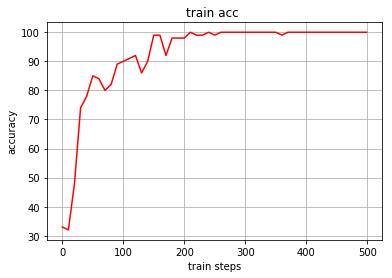

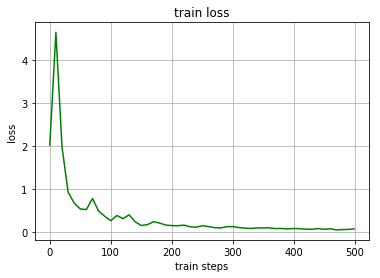

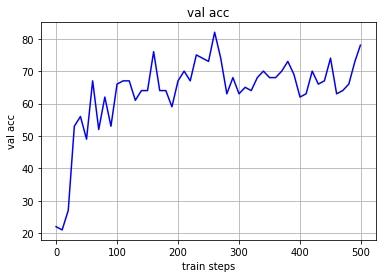

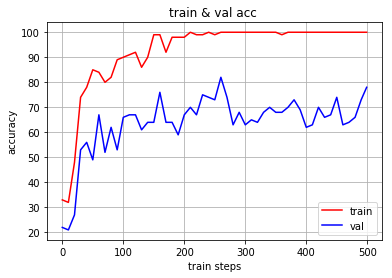

In [7]:
plt.figure()
plt.grid(True)
plt.title('train acc ')
plt.xlabel('train steps')
plt.ylabel('accuracy')
plt.plot(x_steps,train_acc,'r',label='train acc')
plt.show()

plt.grid(True)
plt.title('train loss')
plt.xlabel('train steps')
plt.ylabel('loss')
plt.plot(x_steps,loss,'g',label='train loss')
plt.show()

plt.grid(True)
plt.title('val acc')
plt.xlabel('train steps')
plt.ylabel('val acc')
plt.plot(x_steps,val_acc,'b',label='val acc')
plt.show()

plt.grid(True)
plt.title('train & val acc ')
plt.xlabel('train steps')
plt.ylabel('accuracy')
plt.plot(x_steps,train_acc,'r',label='train acc')
plt.plot(x_steps,val_acc,'b',label='val acc')
plt.legend(['train', 'val'], loc='lower right') 
plt.show()